In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import cv2
from cv2 import aruco
from tqdm import tqdm
import msgpack as mp
import msgpack_numpy as mpn
from datetime import datetime

## Path definition

In [2]:
_pth = os.path.dirname(os.path.dirname(os.getcwd()))
_parent_folder = "data"
_calib_folder_name = "calib_mono_chessboard_corners"

_webcam_calib_folder = os.path.join(
    _pth, _parent_folder, "calibration", _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "test.msgpack")


In [3]:
chessb_corners = mp.Unpacker(open(_webcam_calib_video, 'rb'), object_hook=mpn.decode)
chessb_corners = list(chessb_corners)

In [4]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 30
imgSize = (1200, 480)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)
worldPoints = []
imagePoints = []

In [5]:
def undistortFisheye(imgpath, K, D, DIM, axis, method, scale, corners):
    img = cv2.imread(imgpath)
    """
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, DIM, np.eye(3), balance=0)
    new_K = K.copy()
    new_K[0,0]=K[0,0]*scale
    new_K[1,1]=K[1,1]*scale
    """
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K, D, np.eye(3), K, DIM, cv2.CV_16SC2
    )
    undistorted_img = cv2.remap(
        img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT
    )

    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    undCorners_norm = cv2.fisheye.undistortPoints(corners, K, D)
    undCorners_norm = undCorners_norm.reshape(-1, 2)
    undistCorners = np.zeros_like(undCorners_norm)
    for i, (x, y) in enumerate(undCorners_norm):
        px = x * fx + cx
        py = y * fy + cy
        undistCorners[i, 0] = px
        undistCorners[i, 1] = py
    cv2.drawChessboardCorners(undistorted_img, patternSize, undistCorners, _)

    axs[axis].imshow(undistorted_img[:, :, ::-1])
    axs[axis].axis("off")
    axs[axis].set_title("undistort " + method)
    # cv2.imwrite('undistort'+method+'.png', undistorted_img)

    return corners, undistCorners


def undistortPinhole(imgpath, K, D, DIM, axis, method, corners):
    img = cv2.imread(imgpath)

    new_K, roi = cv2.getOptimalNewCameraMatrix(K, D, DIM, 1, DIM)
    undistorted_img = cv2.undistort(img, K, D, None, new_K)

    undCorners_norm = cv2.undistortPoints(corners, K, D).reshape(-1, 2)
    # remove normalization
    fx = new_K[0, 0]
    fy = new_K[1, 1]
    cx = new_K[0, 2]
    cy = new_K[1, 2]
    undistCorners = np.zeros_like(undCorners_norm)
    for i, (x, y) in enumerate(undCorners_norm):
        px = x * fx + cx
        py = y * fy + cy
        undistCorners[i, 0] = px
        undistCorners[i, 1] = py
    cv2.drawChessboardCorners(undistorted_img, patternSize, undistCorners, _)
    axs[axis].imshow(undistorted_img[:, :, ::-1])
    axs[axis].axis("off")
    axs[axis].set_title("undistorted " + method)

In [6]:
counter = 0
for _f in tqdm(chessb_corners):
    imagePoints.append(_f)
    worldPoints.append(boardPoints)
    counter += 1
    """cv2.drawChessboardCorners(img, patternSize, cornersRefined, ret)
    plt.figure(figsize=(4, 3), dpi=200)
    plt.imshow(img[:,:,::-1])
    plt.axis('off')
    plt.title(fname)"""

  0%|          | 0/630 [00:00<?, ?it/s]

100%|██████████| 630/630 [00:00<00:00, 1349546.23it/s]


In [7]:
if useFisheye:
    flagsCalib = (
        cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
        + cv2.fisheye.CALIB_FIX_SKEW
        + cv2.fisheye.CALIB_CHECK_COND
    )
    calibrateCriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-12)
    ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
        np.expand_dims(np.asarray(worldPoints), -2),
        imagePoints,
        imgSize,
        None,
        None,
        flags=flagsCalib,
        criteria=calibrateCriteria,
    )
else:
    flagsCalib = cv2.CALIB_RATIONAL_MODEL
    ret, cameraMatrix, k, rvecs, tvecs = cv2.calibrateCamera(
        worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
    )

# print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)

RMS re-projection error: 0.3066900919234911
Camera Matrix:
 [[759.78583311   0.         635.30360758]
 [  0.         762.81439633 399.14023285]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-0.0207248 ]
 [ 0.00181033]
 [-0.05370174]
 [ 0.03760771]]


In [19]:
_residual = []

for idx in range(len(t)):
    imgpoints, _ = cv2.fisheye.projectPoints(
        objectPoints=boardPoints.reshape(-1, 1, 3),
        rvec=R[idx].reshape(-1, 3),
        tvec=t[idx].reshape(-1, 3),
        K=cameraMatrix,
        D=k,
    )
    imgpoints = np.array(imgpoints).reshape(-1, 2).astype(float)

    corners = np.array(chessb_corners)[idx]
    corners = corners.reshape(-1, 2)
    _residual.append(corners - imgpoints)

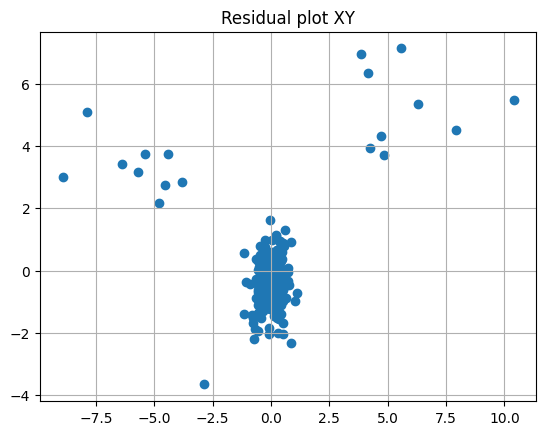

In [20]:
sh = np.array(_residual).shape
_residual = np.array(_residual).reshape(sh[0]*sh[1], sh[2])

plt.scatter(_residual[:, 0], _residual[:, 1])
plt.title("Residual plot XY")
plt.grid("on")

In [32]:
mtx = cameraMatrix
dist = k
tvecs = t
rvecs = R

errors = []
for i in range(len(worldPoints)):
    imgpoints2, _ = cv2.fisheye.projectPoints(worldPoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    errors.append(error)

plt.figure(figsize=(10, 5))
plt.plot(errors, marker='o')
plt.title("Reprojection Error per Image")
plt.xlabel("Image Index")
plt.ylabel("Reprojection Error (pixels)")
plt.show()

error: OpenCV(4.10.0) /io/opencv/modules/calib3d/src/fisheye.cpp:77: error: (-215:Assertion failed) objectPoints.type() == CV_32FC3 || objectPoints.type() == CV_64FC3 in function 'projectPoints'


In [35]:
len(worldPoints)

630

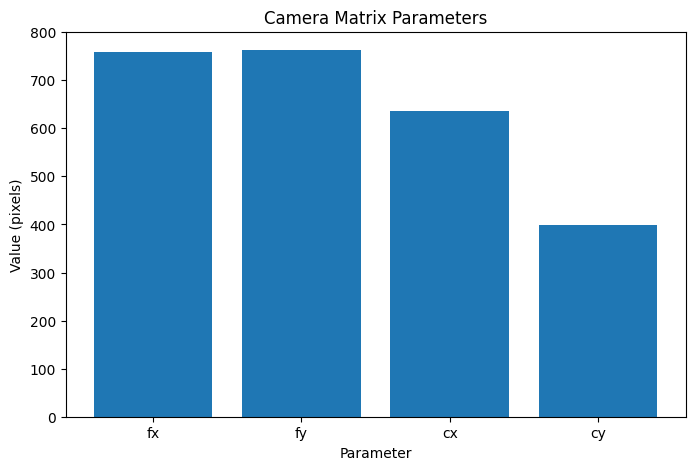

In [36]:
# Extract fx, fy, cx, cy from the camera matrix
fx, fy = mtx[0, 0], mtx[1, 1]
cx, cy = mtx[0, 2], mtx[1, 2]

plt.figure(figsize=(8, 5))
plt.bar(['fx', 'fy', 'cx', 'cy'], [fx, fy, cx, cy])
plt.title("Camera Matrix Parameters")
plt.xlabel("Parameter")
plt.ylabel("Value (pixels)")
plt.show()


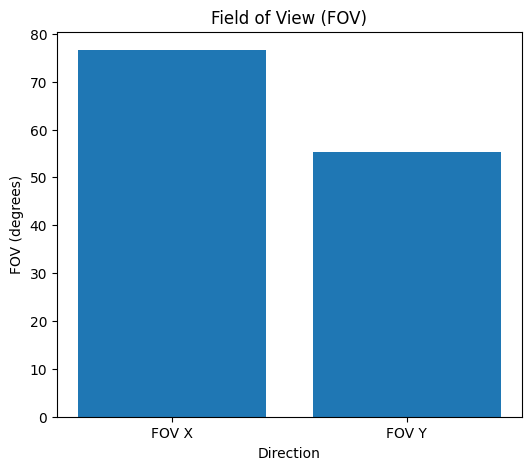

In [38]:
# Calculate horizontal and vertical FOVs (assuming w and h are image dimensions)
w = 1200
h = 800
fov_x = 2 * np.degrees(np.arctan(w / (2 * fx)))
fov_y = 2 * np.degrees(np.arctan(h / (2 * fy)))

plt.figure(figsize=(6, 5))
plt.bar(['FOV X', 'FOV Y'], [fov_x, fov_y])
plt.title("Field of View (FOV)")
plt.xlabel("Direction")
plt.ylabel("FOV (degrees)")
plt.show()

















































































# define calibration file

In [4]:

_recording_dir = os.path.join(os.path.dirname(os.getcwd()), '..', "example_dataset")
_data_dir = "mono2_3d_trial0"
_data_path = os.path.join(
    _recording_dir, "recordings", _data_dir, "webcam_color.msgpack"
)

ar_parameters = aruco.DetectorParameters()
ar_dict = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36H11)
ar_detector = aruco.ArucoDetector(ar_dict, ar_parameters)
markerLength = 0.06
markerSeperation = 0.01

default_ids = [4, 8, 12, 14, 20]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ar_dict,
)

In [4]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)


In [5]:

ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [6]:
calibration_flags = cv2.CALIB_CB_CLUSTERING
term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

In [7]:

corners, ids = [], []
with open(_data_path, "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    img_size = next(unpacker)
    for _frame in tqdm(unpacker):
        _c, _i = _frame
        corners.append(_c)
        ids.append(_i)

timestamp = []
sync = []

with open(
    os.path.join(os.path.dirname(_data_path), "webcam_timestamp.msgpack"), "rb"
) as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _p in unpacker:
        sync.append(_p[0])
        timestamp.append(_p[1])
sync = np.array(sync).astype(bool)

1636it [00:00, 136029.68it/s]
